In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import PIL
from djsetslow import ListSet, IDsSet
from unionfind import UFNaive, UFFast
from skimage.transform import resize
import time

def load_cells_grayscale(filename, n_pixels = 0):
    """
    Load in a grayscale image of the cells, where 1 is maximum brightness
    and 0 is minimum brightness

    Parameters
    ----------
    filename: string
        Path to image holding the cells
    n_pixels: int
        Number of pixels in the image
    """
    cells_original = plt.imread(filename)
    cells_grey = np.asarray(PIL.Image.fromarray(cells_original).convert('L'))
    cells_grey = ndimage.uniform_filter(cells_grey, size=10)
    cells_grey = cells_grey - np.min(cells_grey)
    cells_grey = cells_grey/np.max(cells_grey)
    N = int(np.sqrt(n_pixels))
    if n_pixels > 0:
        cells_grey = resize(cells_grey, (N, N), anti_aliasing=True)
    return cells_grey


In [17]:
def get_cell_labels(I, thresh, uf_class = UFNaive):
    """
    Parameters
    ----------
    I: ndarray(M, N)
        A grayscale image of cells
    thresh: float
        Threshold above which to consider something inside a cell
    uf_class: class
        A data structure that implements the union find ADT.
        Must contain the methods union(i, j), find(i, j), and
        get_set_label(i)
    
    Returns
    -------
    labels: ndarray(M, N)
        An array of labels for the pixels in the image
    """
    M = I.shape[0]
    N = I.shape[1]
    total_length = M+N
    label_arr = []
    for i in range(total_length):
        label_arr.append([])
    # This is the disjoint set object on which you will 
    # call union, find, and get_set_label
    djset = uf_class(M*N) 
    # This is the 2D array of labels that you will fill
    # in and return
    labels = np.ones((M, N), dtype=int)
    index = 0
    for x in range(M*N):
        label_arr[index] = [x,y]
        index+=1
         #labels populated with the pixels, via the above loop
    index_thresh = 0
    index_thresh_2 = 1
    label_index = 0
    for index_thresh in range(len(label_arr)):
        if index_thresh_2 == len(label_arr):
            index_thresh+=1
        elif I[label_arr[index_thresh]] > thresh and I[label_arr[index_thresh]]:
            labels[index_thresh] = djset.union(label_arr[index_thresh], label_arr[index_thresh_2])
            index_thresh+=1
            index_thresh_2+=1
        else:
            index_thresh+=1
            index_thresh_2+=1
            
    return labels


In [12]:
def get_cluster_centers(labels):
    """
    Compute an array that holds the row and column of the
    mean of each label location that has more than 1 pixel
    assigned to it

    Parameters
    ----------
    labels: ndarray(M, N)
        An array of labels for the pixels in the image
    
    Returns
    -------
    X: ndarray(K, 2)
        An array of average row/column indices of each of the
        K labels that had at least 2 pixels assigned to them
    """
    X = []
    for i in enumerate(labels):
        X.append([])
    for x, y in labels: 
        ave_1 = 0
        ave_2 = 0
        aver = 0
        ave_1, ave_2 = labels[x,y]
        aver = (ave_1+ave_2)/len(labels)
        X[xy] = aver
    return X 

'\nif __name__ == \'__main__\':\n    thresh = 0.8\n    I = load_cells_grayscale("Cells.jpg")\n    labels = get_cell_labels(I, thresh)\n    plt.imshow(permute_labels(labels))\n    plt.savefig("labels.png", bbox_inches=\'tight\')\n    '

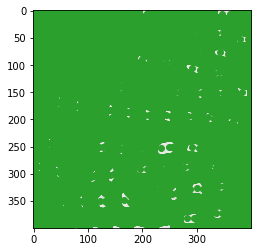

In [5]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import PIL
from djsetslow import ListSet, IDsSet
from unionfind import UFNaive, UFFast
from skimage.transform import resize
import time

def load_cells_grayscale(filename, n_pixels = 0):
    """
    Load in a grayscale image of the cells, where 1 is maximum brightness
    and 0 is minimum brightness

    Parameters
    ----------
    filename: string
        Path to image holding the cells
    n_pixels: int
        Number of pixels in the image
    """
    cells_original = plt.imread(filename)
    cells_grey = np.asarray(PIL.Image.fromarray(cells_original).convert('L'))
    cells_grey = ndimage.uniform_filter(cells_grey, size=10)
    cells_grey = cells_grey - np.min(cells_grey)
    cells_grey = cells_grey/np.max(cells_grey)
    N = int(np.sqrt(n_pixels))
    if n_pixels > 0:
        cells_grey = resize(cells_grey, (N, N), anti_aliasing=True)
    return cells_grey

def get_cell_labels(I, thresh, uf_class = UFNaive):
    """
    Parameters
    ----------
    I: ndarray(M, N)
        A grayscale image of cells
    thresh: float
        Threshold above which to consider something inside a cell
    uf_class: class
        A data structure that implements the union find ADT.
        Must contain the methods union(i, j), find(i, j), and
        get_set_label(i)
    
    Returns
    -------
    labels: ndarray(M, N)
        An array of labels for the pixels in the image
    """
    M = I.shape[0]
    N = I.shape[1]
    ident = np.zeros((M, N), dtype=int) #2d array meant to hold identities of each pixel
                                        #horizontally incriments l->r
    i = 0 
    for y in range(M):
        for x in range(N):
            ident[y][x] = i #populates the array
            i += 1
    # This is the disjoint set object on which you will 
    # call union, find, and get_set_label
    djset = uf_class(M*N) 
    # This is the 2D array of labels that you will fill
    # in and return
    labels = np.ones((M, N), dtype=int) #populate labels, 2d array
    for y in range(M):
        for x in range(N):
            if y == (N-1) or x==(M-1):
                break
            elif I[y, x]> thresh and I[y+1, x] > thresh:
                djset.union(ident[y,x], ident[y+1, x])
            elif I[y,x] > thresh and I[y,x+1] > thresh:
                djset.union(ident[y, x], ident[y,x+1])
    for y in range(M):
        for x in range(N):
            labels[y][x] = djset.get_set_label(ident[y][x])
            
    return labels

def permute_labels(labels):
    """
    Shuffle around labels by raising them to a prime and
    modding by a large-ish prime, so that cells are easier
    to see against their backround
    Parameters
    ----------
    labels: ndarray(M, N)
        An array of labels for the pixels in the image

    Returns
    -------
    labels_shuffled: ndarray(M, N)
        A new image where the labels are different but still
        the same within connected components
    """
    return (labels**31) % 833


def get_cluster_centers(labels):
    """
    Compute an array that holds the row and column of the
    mean of each label location that has more than 1 pixel
    assigned to it

    Parameters
    ----------
    labels: ndarray(M, N)
        An array of labels for the pixels in the image
    
    Returns
    -------
    X: ndarray(K, 2)
        An array of average row/column indices of each of the
        K labels that had at least 2 pixels assigned to them
    """
    M = labels.shape[0]
    N = labels.shape[1]
    pixels = []
    X = []
    for y in range(M):
        for x in range(N):
            pixels.append([[]])
    for y in range(M):
        for x in range(N):
            pixels[labels[y][x]].append([y, x])
    for i, val in enumerate(pixels):
        if len(val) > 2:
            avg = []
            temp_x = 0
            temp_y = 0
            for z in range(len(val)):
                avg+=val[z]
            for n in range(len(avg)):
                if n%2 == 0:
                    temp_y+= avg[n]
                else:
                    temp_x+=avg[n]
            temp_y = temp_y/int(.5*len(avg))
            temp_x = temp_x/int(.5*len(avg))
            avg = [temp_y, temp_x]
            X.append(avg)
    return X # This is a dummy value, but you should return
    # a list of [row, column] lists representing the centers

def time_test():
    thresh = 0.7
    n_pixels = []
    times_idsset = []
    times_uffast = []
    temp_1 = []
    temp_2 = []
    for n in range(100, 100*100, 500):
        n_pixels.append(n)
        I = load_cells_grayscale("Cells.jpg", n)
        tic_1 = time.time()
        temp_1 = get_cell_labels(I, thresh, uf_class = UFNaive)
        elapsed_1 = time.time() - tic_1
        avg_1 = elapsed_1/(len(n_pixels))
        times_idsset.append(avg_1)
        tic_2 = time.time()
        temp_2 = get_cell_labels(I, thresh, uf_class = UFFast)
        elapsed_2 = time.time()-tic_2
        avg_2 = elapsed_2/(len(n_pixels))
        times_uffast.append(avg_2)
    plt.plot(n_pixels, times_idsset)
    plt.plot(n_pixels, times_uffast)
    plt.legend(["IDsSet", "UFFast"])
    plt.xlabel("Number of pixels")
    plt.ylabel("Average Elapsed Time Per Operation")
    plt.savefig("Timings.png", bbox_inches='tight')

if __name__ == '__main__':
    thresh = 0.7
    I = load_cells_grayscale("Cells.jpg")
    labels = get_cell_labels(I, thresh)
    cells_original = plt.imread("Cells.jpg")
    X = get_cluster_centers(labels)
    X = np.array(X)
    plt.imshow(cells_original)
    plt.scatter(X[:, 1], X[:, 0], c='C2')
    plt.savefig("cells_marked.png")
    """

if __name__ == '__main__':
    time_test()
    thresh = 0.7
    I = load_cells_grayscale("Cells.jpg")
    labels = get_cell_labels(I, thresh)
    plt.imshow(permute_labels(labels))
    plt.savefig("labels.png", bbox_inches='tight')
    cells_original = plt.imread("Cells.jpg")
    X = get_cluster_centers(labels)
    X = np.array(X)
    plt.imshow(cells_original)
    plt.scatter(X[:, 1], X[:, 0], c='C2')
    plt.savefig("cells_marked.png")"""
"""
if __name__ == '__main__':
    thresh = 0.8
    I = load_cells_grayscale("Cells.jpg")
    labels = get_cell_labels(I, thresh)
    plt.imshow(permute_labels(labels))
    plt.savefig("labels.png", bbox_inches='tight')
    """

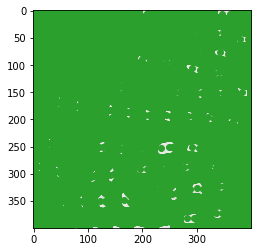

In [6]:
if __name__ == '__main__':
    thresh = 0.7
    I = load_cells_grayscale("Cells.jpg")
    labels = get_cell_labels(I, thresh)
    cells_original = plt.imread("Cells.jpg")
    X = get_cluster_centers(labels)
    X = np.array(X)
    plt.imshow(cells_original)
    plt.scatter(X[:, 1], X[:, 0], c='C2')
    plt.savefig("cells_marked.png")